In [59]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score

In [60]:
df = pd.read_csv('DataBase.csv')
df

,time,input
0,110.062839,4034.0
1,110.141765,4045.0
2,110.221532,4059.0
3,110.301835,4044.0
4,110.382143,4043.0
...,...,...
1344,218.932480,4095.0
1345,219.012188,4095.0
1346,219.092119,4095.0
1347,219.172231,4095.0


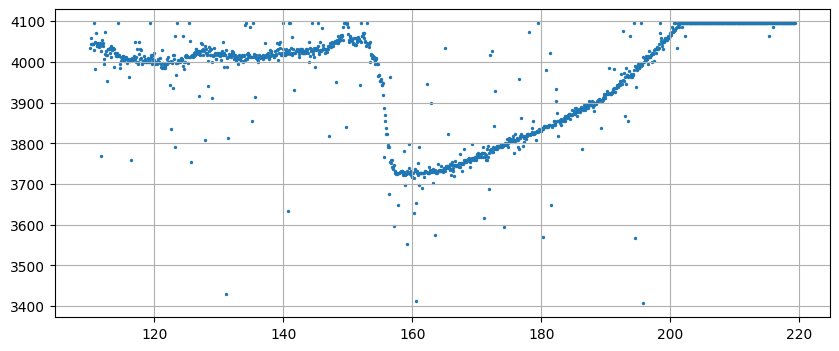

In [61]:
plt.figure(figsize=(10, 4))
plt.scatter(df.time, df.input, s=2)
plt.grid()

# NORMALIZANDO DADOS

In [62]:
dt = 0.030

In [ ]:
def normalizeTable(df, key, dt=0.15):
    df[key]  = df[key] - df[key][0] # INICIA NO TEMPO 0
    initTime = df[key].iloc[0]
    finalTime = df[key].iloc[-1] + dt
    newAxis = np.arange(initTime, finalTime, dt)
    df = df.set_index(key).reindex(newAxis, method='ffill')
    return df.reset_index().rename(columns={'index': key})


df = normalizeTable(df, 'time', dt)
df.head()

,time,input
0,0.00,4034.0
1,0.03,4034.0
2,0.06,4034.0
3,0.09,4045.0
4,0.12,4045.0


# FILTROS

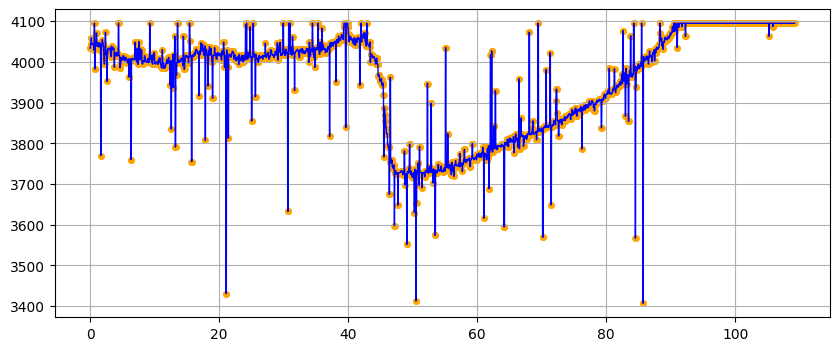

In [64]:
xData, yData = df.time.values, df.input.values

plt.figure(figsize=(10, 4))
plt.scatter(xData, yData, s=15, color='orange')
plt.plot(xData, yData, linewidth=1, color='blue')
plt.grid()

### PASSA BAIXA

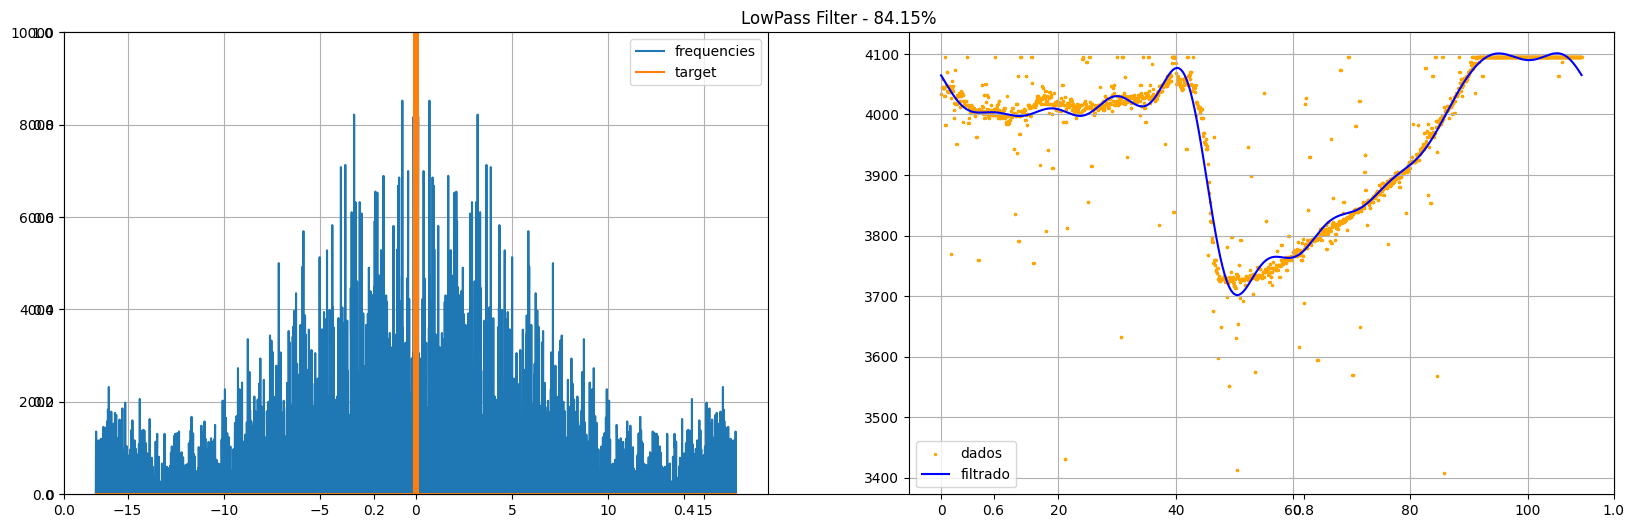

In [65]:
class LowBandFilter:
    yModel = None
    yMag   = None
    yFreq  = None

    def __init__(self, xData, yData):
        self.dt = (xData[2] - xData[0])/2 
        self.xData = xData
        self.yData = yData

    def setFrequencies(self):
        self.yMag  = np.fft.fft(self.yData)
        self.yFreq = np.fft.fftfreq(len(self.yData), self.dt)

    def apply(self, Fc=0.1):
        self.setFrequencies()
        allowed = (np.abs(self.yFreq) <= Fc)
        self.yMag[~allowed] = 0
        self.yModel = np.fft.ifft(self.yMag).real
        return self.yModel
    
    def show(self):
        plt.figure(figsize=(20, 6))
        prec = r2_score(self.yModel, self.yData)
        plt.title(f'LowPass Filter - {prec*100:.2f}%')
        plt.subplot(1, 2, 1)
        plt.plot(np.fft.fftfreq(len(yData), dt), np.fft.fft(yData).real, label='frequencies')
        plt.plot(self.yFreq, self.yMag.real, label='target')
        plt.ylim(0, 10000)
        plt.grid(), plt.legend()
        plt.subplot(1, 2, 2)
        plt.scatter(df.time, df.input, s=2, color='orange', label='dados')
        plt.plot(xData, self.yModel, color='blue', label='filtrado')
        plt.legend(), plt.grid()
        plt.show()


filter = LowBandFilter(xData, yData)
yModel = filter.apply(Fc=0.1)
filter.show()

### KALMAN FILTER

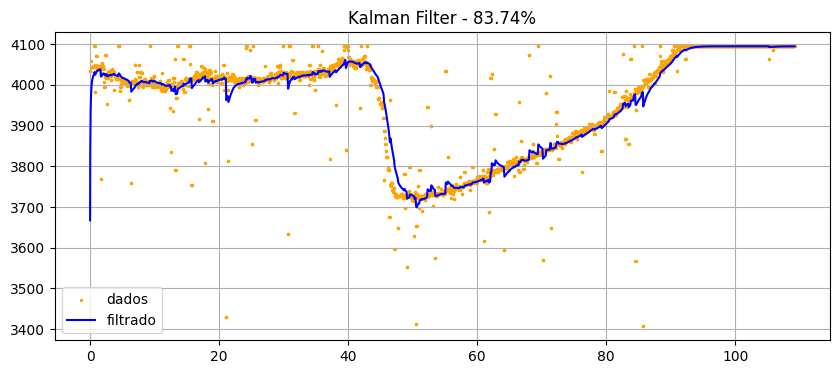

In [66]:
class KalmanFilter:
    xData  = None
    yData  = None
    yModel = None

    def __init__(self, A, B, H, Q, R, P, x):
        self.A = A
        self.B = B
        self.H = H
        self.Q = Q
        self.R = R
        self.P = P
        self.x = x

    def predict(self, u=0):
        self.x = np.dot(self.A, self.x) + np.dot(self.B, u)
        self.P = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q

    def update(self, z):
        y = z - np.dot(self.H, self.x)  # Inovação
        S = np.dot(np.dot(self.H, self.P), self.H.T) + self.R  # Covariância da inovação
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))  # Ganho de Kalman
        self.x = self.x + np.dot(K, y)
        I = np.eye(self.A.shape[0])  # Matriz identidade
        self.P = np.dot(I - np.dot(K, self.H), self.P)

    def predictFuture(self, steps, U=None):
        original_x = self.x.copy()  # Salva o estado atual
        original_P = self.P.copy()  # Salva a covariância atual

        predictions = []
        u_index = 0

        for step in range(steps):
            if U is not None and u_index < len(U):
                u = np.array(U[u_index]).reshape(-1, 1)  # Transforma em vetor coluna
                u_index += 1
            else:
                u = np.zeros((self.B.shape[1], 1))  # Entrada padrão: zero

            self.predict(u)
            predictions.append(self.x.copy())  # Salva o estado predito

        self.x = original_x  # Restaura o estado original
        self.P = original_P  # Restaura a covariância original
        return predictions

    def getState(self):
        return self.x
    
    def apply(self, xData, yData):
        self.xData = xData
        self.yData = yData
        self.yModel = []

        for u in yData:
            U = np.array([[u]])
            kalman.predict()
            kalman.update(U)
            result = kalman.getState()[0, 0]
            self.yModel.append(result)

        return self.yModel
    
    def show(self):
        prec = r2_score(self.yModel, self.yData)
        plt.figure(figsize=(10, 4))
        plt.title(f'Kalman Filter - {prec*100:.2f}%')
        plt.scatter(self.xData, self.yData, s=2, color='orange', label='dados')
        plt.plot(self.xData, self.yModel, color='blue', label='filtrado')
        plt.legend(), plt.grid()
        plt.show()


A = np.array([[1]])     # Estado constante
B = np.array([[0]])     # Sem controle
H = np.array([[1]])     # Observação direta
Q = np.array([[1e-4]])  # Variância do processo
R = np.array([[0.1]])   # Variância da medição
P = np.array([[1]])     # Covariância inicial
x = np.array([[0]])     # Estado inicial

kalman = KalmanFilter(A, B, H, Q, R, P, x)
yModel = kalman.apply(xData, yData)
kalman.show()

### Savitzky-Golay 
Este filtro ajusta um polinômio de baixa ordem a uma janela deslizante de pontos de dados, preservando a forma geral dos dados (como picos e vales) enquanto suaviza o ruído. Ideal para preservar as características da curva.

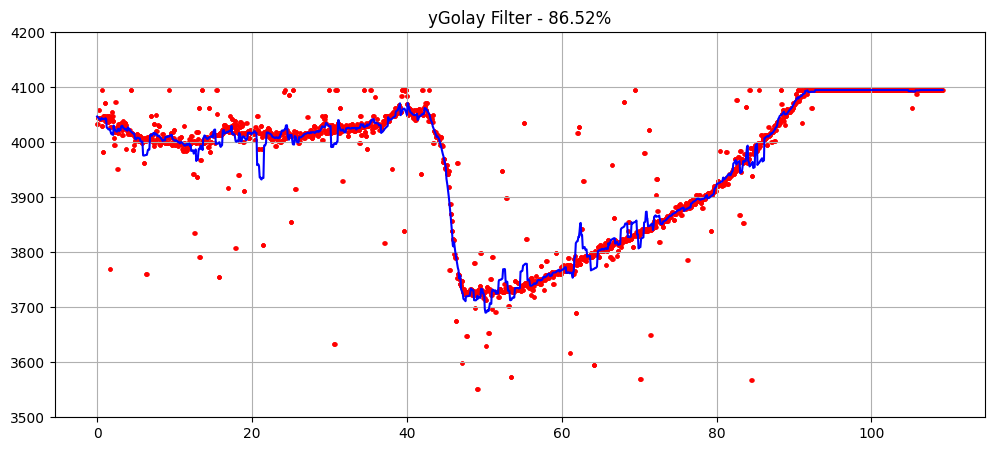

In [67]:
from scipy.signal import savgol_filter
yModel = savgol_filter(yData, window_length=30, polyorder=1)

plt.figure(figsize=(12, 5))
prec = r2_score(yModel, yData)
plt.title(f'yGolay Filter - {prec*100:.2f}%')
plt.scatter(xData, yData, s=5, color='red')
plt.plot(xData, yModel, color='blue')
plt.ylim(3500, 4200)
plt.grid()

### Filtro de Média Móvel
Esse é um filtro simples e eficaz, que substitui cada ponto de dados pela média dos pontos em uma janela móvel.

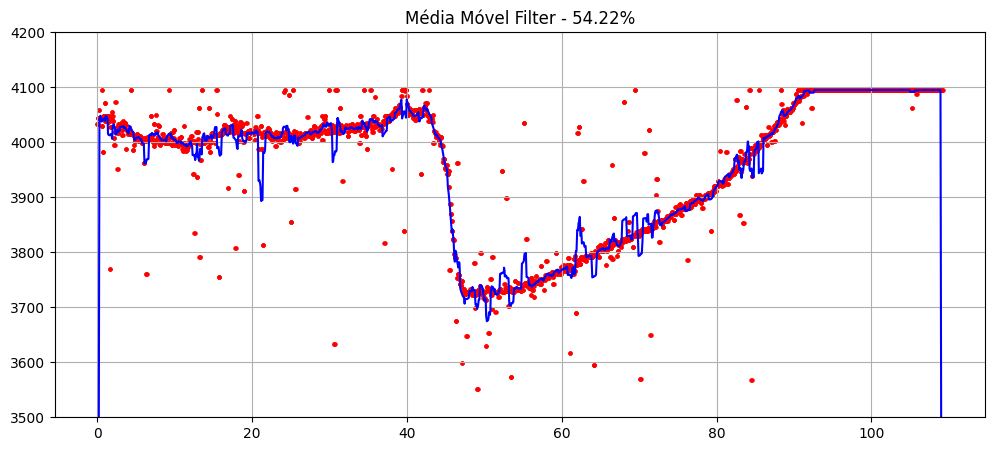

In [68]:
from numpy import convolve
windowSize = 20
yModel = convolve(yData, np.ones(windowSize) / windowSize, mode='same')

plt.figure(figsize=(12, 5))
prec = r2_score(yModel, yData)
plt.title(f'Média Móvel Filter - {prec*100:.2f}%')
plt.scatter(xData, yData, s=5, color='red')
plt.plot(xData, yModel, color='blue')
plt.ylim(3500, 4200)
plt.grid()

### Filtro Gaussiano
Esse filtro aplica uma função gaussiana aos dados em uma janela, o que resulta em uma suavização mais natural e contínua.

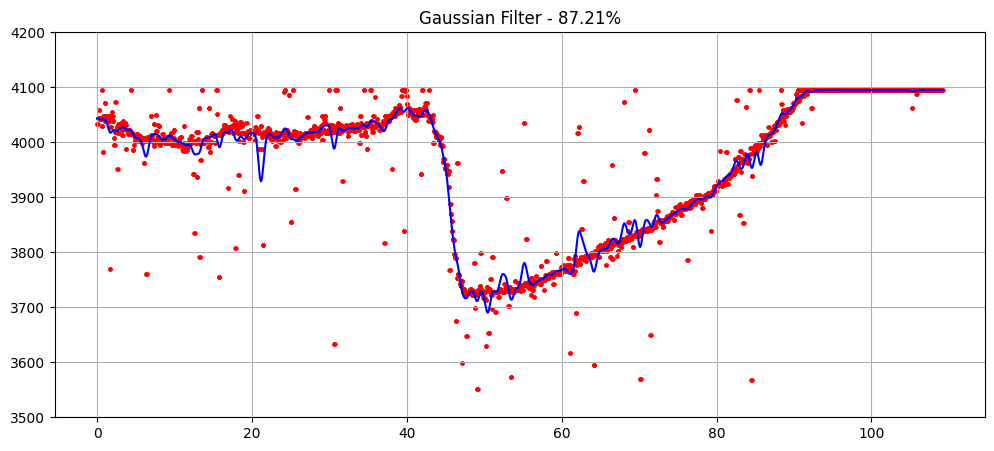

In [69]:
from scipy.ndimage import gaussian_filter
yModel = gaussian_filter(yData, sigma=10)

plt.figure(figsize=(12, 5))
prec = r2_score(yModel, yData)
plt.title(f'Gaussian Filter - {prec*100:.2f}%')
plt.scatter(xData, yData, s=5, color='red')
plt.plot(xData, yModel, color='blue')
plt.ylim(3500, 4200)
plt.grid()

### Filtro de Média Exponencial
Esse método dá mais peso aos valores mais recentes, o que é útil para séries temporais.

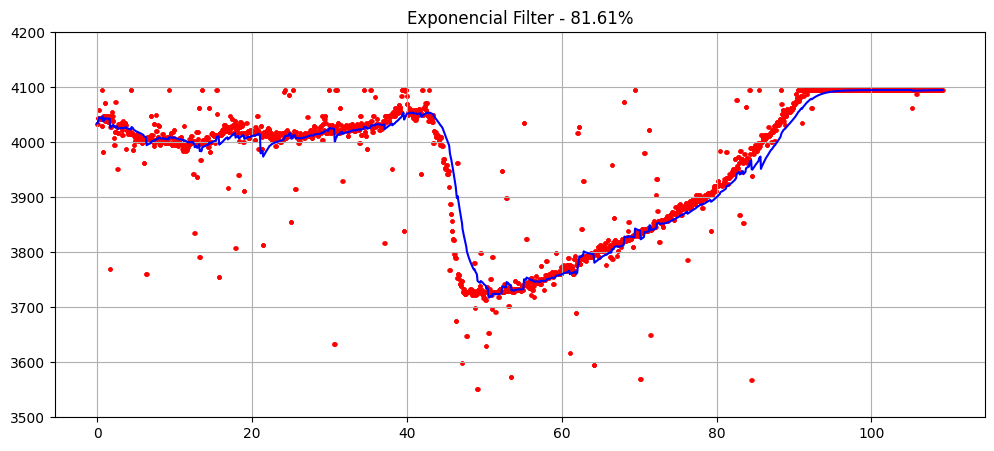

In [70]:
yModel = pd.Series(yData).ewm(alpha=0.02).mean().to_numpy()

plt.figure(figsize=(12, 5))
prec = r2_score(yModel, yData)
plt.title(f'Exponencial Filter - {prec*100:.2f}%')
plt.scatter(xData, yData, s=5, color='red')
plt.plot(xData, yModel, color='blue')
plt.ylim(3500, 4200)
plt.grid()

### Filtro de Butterworth
É um filtro passa-baixas que elimina componentes de alta frequência e é muito usado para sinais onde queremos eliminar ruídos de alta frequência.

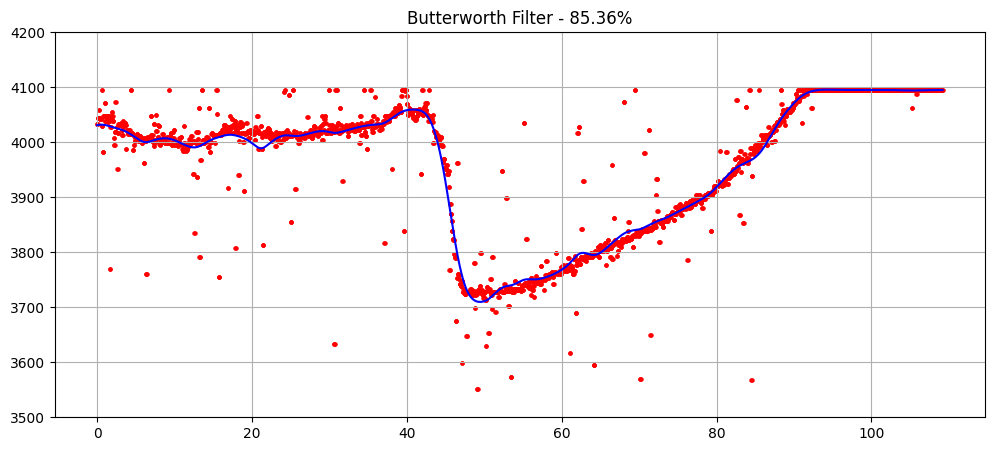

In [71]:
from scipy.signal import butter, filtfilt

order = 2           # Ordem do filtro
cutoff_freq = 0.01  # Frequência de corte (ajuste conforme seu sinal)
b, a = butter(order, cutoff_freq, btype='low', analog=False)
yModel = filtfilt(b, a, yData)

plt.figure(figsize=(12, 5))
prec = r2_score(yModel, yData)
plt.title(f'Butterworth Filter - {prec*100:.2f}%')
plt.scatter(xData, yData, s=5, color='red')
plt.plot(xData, yModel, color='blue')
plt.ylim(3500, 4200)
plt.grid()

# FILTRO DE LAPLACE

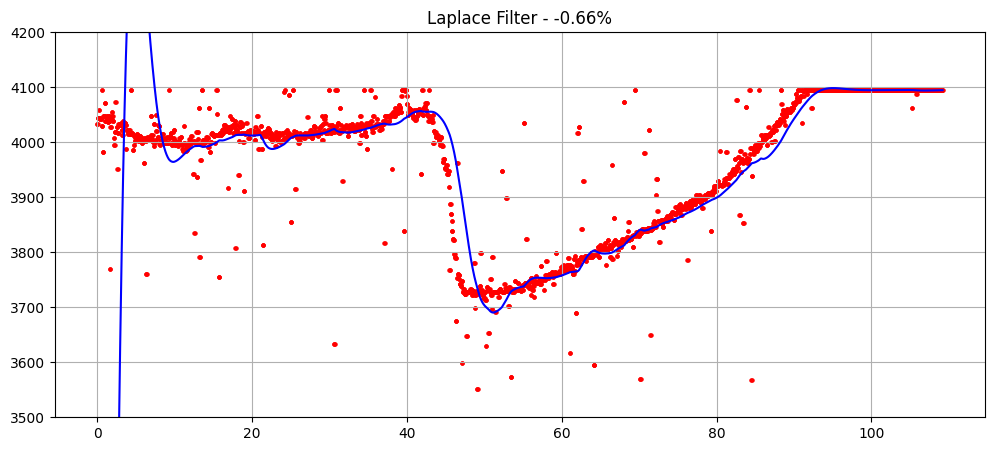

In [72]:
import control as ctl


class LaplaceFilter:
    num = []
    den = []
    
    def __init__(self, Ts=1.0, UP=0.1, dt=0.05, Tp=None):
        zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
        Wn   = 4/(zeta*Ts)

        if Tp is not None:
            Wn = np.pi/(Tp*np.sqrt(1 - zeta**2))

        s = ctl.TransferFunction.s
        C = Wn**2/(s**2 + 2*zeta*Wn*s + Wn**2)

        C_z = ctl.c2d(C, dt, method='tustin')
        self.num, self.den = self.getFraction(C_z)
        self.Xn = np.zeros_like(self.num)
        self.Yn = np.zeros_like(self.den)
        self.dt = dt

    def getFraction(self, G_z):
        num, den = ctl.tfdata(G_z)
        num = np.squeeze(num)
        den = np.squeeze(den)

        num = num/den[0]
        den = den/den[0]

        if type(num) == np.float64:
            num = np.array([num])

        num = [float(val) for val in num]
        den = [float(val) for val in den]
        return (num, den) 

    def compute(self):
        out = 0.0

        for i in range(0, len(self.num)):
            out += self.Xn[i]*(self.num[i])
        
        for i in range(1, len(self.den)):
            out += self.Yn[i]*(-1*self.den[i])

        return out

    def update(self, input):
        for n in range(len(self.num)-1, 0, -1):
            self.Xn[n] = self.Xn[n-1]

        for n in range(len(self.den)-1, 0, -1):
            self.Yn[n] = self.Yn[n-1]
        
        self.Xn[0] = input
        self.Yn[0] = self.compute()
        return self.Yn[0]
    

filter = LaplaceFilter(Tp=5.0, UP=0.1, dt=dt)
yModel = np.array([filter.update(val) for val in yData])

plt.figure(figsize=(12, 5))
prec = r2_score(yModel, yData)
plt.title(f'Laplace Filter - {prec*100:.2f}%')
plt.scatter(xData, yData, s=5, color='red')
plt.plot(xData, yModel, color='blue')
plt.ylim(3500, 4200)
plt.grid()

# COMBINAÇÃO DE FITLROS

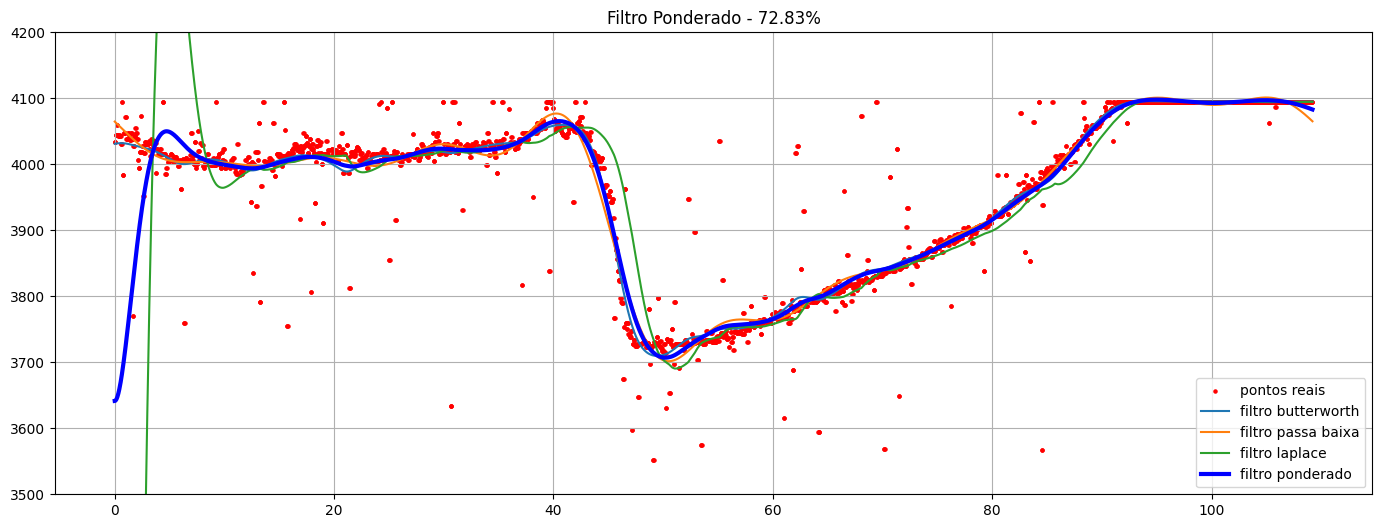

In [73]:
def applyWheights(yButt, yLowPass, yLaplace):
    return 0.5*yButt + 0.4*yLowPass + 0.1*yLaplace


b, a  = butter(2, 0.01, btype='low', analog=False)
yButt = filtfilt(b, a, yData)

filter   = LaplaceFilter(Tp=5.0, UP=0.1, dt=dt)
yLaplace = np.array([filter.update(val) for val in yData])

filter = LowBandFilter(xData, yData)
yLowPass = filter.apply(Fc=0.1)

yModel = applyWheights(yButt, yLowPass, yLaplace)
prec   = r2_score(yModel, yData)

plt.figure(figsize=(17, 6))
plt.title(f'Filtro Ponderado - {prec*100:.2f}%')
plt.scatter(xData, yData, s=5, color='red', label='pontos reais')
plt.plot(xData, yButt,    label='filtro butterworth')
plt.plot(xData, yLowPass, label='filtro passa baixa')
plt.plot(xData, yLaplace, label='filtro laplace')
plt.plot(xData, yModel, label='filtro ponderado', linewidth=3, color='blue')
plt.ylim(3500, 4200), plt.grid(), plt.legend()
plt.show()

# SMART SELECTION

In [74]:
from sklearn.linear_model import LinearRegression

In [75]:
M = np.column_stack([
    yButt, 
    yLowPass, 
    yLaplace
])

model = LinearRegression()
model.fit(M, yData)

LinearRegression()

In [76]:
coefs, intercept = model.coef_, model.intercept_

print(coefs)
print(intercept)

[ 1.36474151 -0.35989565 -0.00396892]
-3.6076167401961357


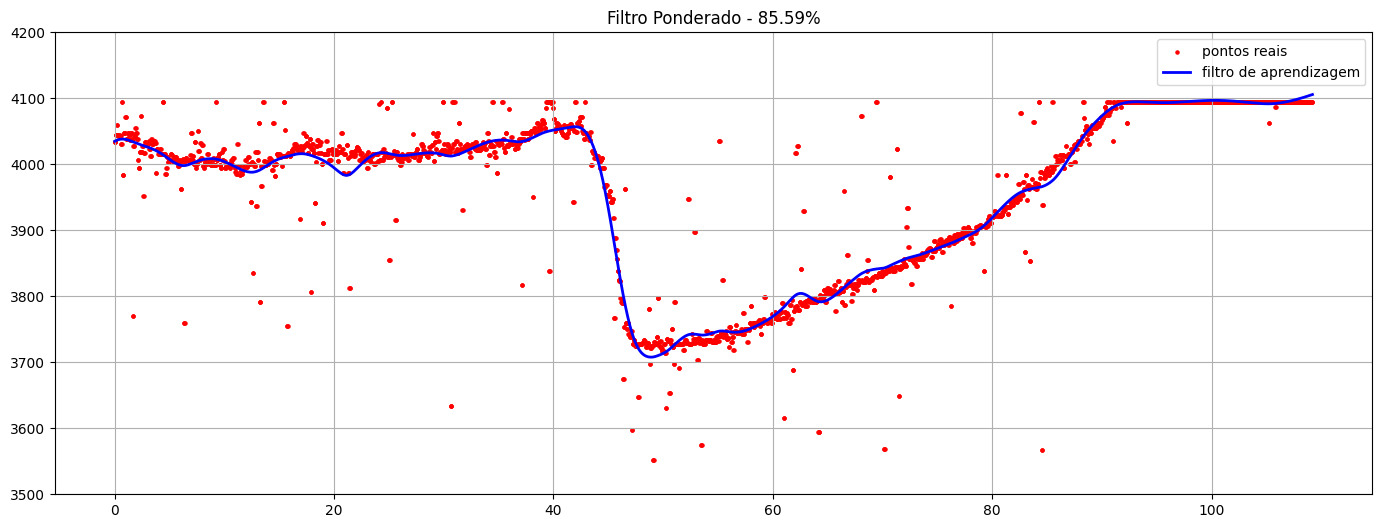

In [77]:
def applyWheights(yButt, yLowPass, yLaplace):
    return 1.36474151*yButt - 0.35989565*yLowPass - 0.00396892*yLaplace - 3.607616740196135

yModel = applyWheights(yButt, yLowPass, yLaplace)
prec   = r2_score(yModel, yData)

plt.figure(figsize=(17, 6))
plt.title(f'Filtro Ponderado - {prec*100:.2f}%')
plt.scatter(xData, yData, s=5, color='red', label='pontos reais')
plt.plot(xData, yModel, label='filtro de aprendizagem', linewidth=2, color='blue')
plt.ylim(3500, 4200), plt.grid(), plt.legend()
plt.show()